In [1]:
import numpy as np
import sklearn
import scipy
import diabeticRetinopathyUtils

from datetime import datetime
from collections import defaultdict

from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams.update({'font.size': 25})

In [2]:
X, y = diabeticRetinopathyUtils.load_diabetic_retinopathy(
    './diabeticRetinopathy.csv')
n = len(y)
rho = 1 / n
w = np.zeros_like(X[0])
w_0 = 0
Xone = np.hstack([X, np.ones(len(y)).reshape(-1, 1)])

# 1 Régularisation de Tikhonov

On veut résoudre le problème suivant
$$ \min_{\omega_0 \in \mathbb{R}, \omega \in \mathbb{R}} \frac{1}{n} \sum_{i=1}^n log(1 + exp(-y_i(x^T_i \omega + \omega_0))) + \frac{\rho}{2} \| \omega \|^2_2 $$

## Question 1.1

Calculer le gradient de $ f_1 : (\omega_0, \omega) \mapsto \frac{1}{n} \sum_{i=1}^n log(1 + exp(-y_i(x^T_i \omega + \omega_0))) + \frac{\rho}{2} \| \omega \|^2_2 $ et sa matrice hessienne. La fonction est-elle convexe ?

## Reponse 1.1

Le gradient:

$$ \frac{\partial f_1}{\partial \omega} = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i(x^T_i \omega + \omega_0))}{1 + exp(-y_i(x^T_i \omega + \omega_0))} (-y_i x_i) + \rho \omega  $$

$$ \frac{\partial f_1}{\partial \omega_0} = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i(x^T_i \omega + \omega_0))}{1 + exp(-y_i(x^T_i \omega + \omega_0))} (-y_i) $$

Si on rajoute colonne de uns à la matrice X:

$$ \frac{\partial f_1}{\partial \omega_k } = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i x^T_i \omega)}{1 + exp(-y_i x^T_i \omega)} (-y_i x_{ik}) + \rho \omega_k $$ 

$$ G = \frac{1}{n}  (diag(-y) X)^Td + \rho \omega $$

La matrice hessienne:

$$ \frac{\partial f_1}{\partial \omega_k \omega_l } = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i x^T_i \omega)}{[1 + exp(-y_i x^T_i \omega)]^2} (x_{ik}x_{il}) , \quad si \quad k \neq l $$ 

$$ \frac{\partial f_1}{\partial \omega_k \omega_l } = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i x^T_i \omega)}{[1 + exp(-y_i x^T_i \omega)]^2} (x_{ik}x_{il}) + \rho , \quad si \quad k = l $$ 

$$ H = \frac{1}{n} X^T D X + \rho I $$ ou $$ D = diag \left( \frac{exp(-y_i x_i^T \omega)}{[1+exp(-y_i x_i^T \omega)]^2} \right) $$


La fonction est **convexe**, parce que la matrice Hessienne est defini positive (tous les éléments de $D$ sont positifs et on peut réécrire $H \propto X^T (D^{1/2})^T D^{1/2} X $

---

## Question 1.2
Coder une fonction qui retourne la valeur de la fonction, son gradient et sa hessienne. Vous
utiliserez la base de données diabeticRetinopathy fournie et $\rho = 1/n$. Il pourra être pra-
tique de rajouter une colonne de uns à la matrice X.

Tester votre calcul de gradient avec la fonction **check grad.**

In [3]:
class LogReg_L2RegOracle():
    def __init__(self, X, y, rho):
        self._X = X
        self._y = y
        self._rho = rho

    def func(self, w):
        mask = np.ones_like(w)
        mask[-1] = 0

        tmp = -self._y * np.dot(self._X, w)
        return np.mean(np.log(1 + np.exp(tmp))) + 0.5 * self._rho * np.linalg.norm(mask * w)**2

    def grad(self, w):
        mask = np.ones_like(w)
        mask[-1] = 0

        tmp = -self._y * np.dot(self._X, w)
        d = np.exp(tmp) / (1 + np.exp(tmp))
        return np.dot(np.diag(-self._y), self._X).T.dot(d) / len(self._y) + self._rho * mask * w

    def hess(self, w):
        tmp = -self._y * np.dot(self._X, w)
        D = np.diag(np.exp(tmp) / (1 + np.exp(tmp))**2)

        mask = np.eye(len(w))
        mask[-1, -1] = 0

        H = self._X.T.dot(D).dot(self._X) / len(self._y) + self._rho * mask
        return H

In [4]:
oracle = LogReg_L2RegOracle(Xone, y, rho)
scipy.optimize.check_grad(
    func=oracle.func, grad=oracle.grad, x0=np.hstack([w, w_0]))

3.6692715433412983e-08

In [5]:
g = lambda x: np.sum(oracle.grad(x))
h = lambda x: np.sum(oracle.hess(x), axis=1)
scipy.optimize.check_grad(func=g, grad=h, x0=np.hstack([w, w_0]))

4.86750533396293e-08

---

## Question 1.3
Coder la méthode de Newton et la lancer avec comme condition initiale $(\omega^0_0, \omega^0 ) = 0$ et
comme test d’arrêt $ \| \nabla f_1 (\omega) \|_2 < 10^{−10} $. Afficher la norme du gradient en fonction des
itérations en échelle logarithmique.

$$\mathbf {x} _{n+1}=\mathbf {x} _{n}-\gamma [\mathbf {H} f(\mathbf {x} _{n})]^{-1}\nabla f(\mathbf {x} _{n}).$$

In [6]:
def newton_method(oracle,
                  x_0,
                  gamma=1,
                  eps=1e-10,
                  max_iter=1000,
                  trace=False,
                  display=False):
    """
    Newton's optimization method.
    Parameters
    ----------
    oracle : 
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. 
    x_0 : np.array
        Starting point for optimization algorithm
    gamma : float
        Learning rate
    eps : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
        
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
    Example:
    --------
    >> oracle = LogRegOracle(np.eye(5), np.arange(5), 0.3)
    >> x_opt, _ = newton_method(oracle, np.zeros(5))
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.          0.28599049  0.408522    0.43084653  2.32020331]
    """
    start_time = datetime.now()
    history = defaultdict(list) if trace else None

    x = x_0.copy()

    for i in range(max_iter):
        grad = oracle.grad(x)
        H = oracle.hess(x)
        x = x - gamma * np.linalg.inv(H).dot(grad)

        grad_norm = np.linalg.norm(grad)
        if grad_norm <= eps:
            break

        if display:
            print('func: %f, grad_norm = %f' % (oracle.func(x), grad_norm))

        if trace:
            history['time'].append(
                (datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x))
            history['grad_norm'].append(grad_norm)

    return x, history

In [7]:
%%time
oracle = LogReg_L2RegOracle(Xone, y, rho)

w = np.zeros_like(X[0])
w_0 = 0

x, history = newton_method(
    oracle,
    x_0=np.hstack([w, w_0]),
    gamma=1,
    eps=1e-10,
    trace=True,
    display=True)
history['label'] = 'simple newton method'

func: 0.569517, grad_norm = 0.328785
func: 0.539868, grad_norm = 0.088914
func: 0.532753, grad_norm = 0.030715
func: 0.530306, grad_norm = 0.011683
func: 0.530029, grad_norm = 0.003388
func: 0.530019, grad_norm = 0.000735
func: 0.530019, grad_norm = 0.000065
func: 0.530019, grad_norm = 0.000001
CPU times: user 312 ms, sys: 788 ms, total: 1.1 s
Wall time: 163 ms


In [8]:
def plot_res_logscale(histories, to_plot='grad_norm'):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_yscale("log", nonposy='clip')

    for h in histories:
        plt.plot(h[to_plot], label=str(h['label']))

    plt.title('norm du gradient en fonction d\'iteration')
    plt.xlabel('iteration')
    plt.ylabel(r'$||\nabla f||_2$')
    plt.legend()

    plt.show()

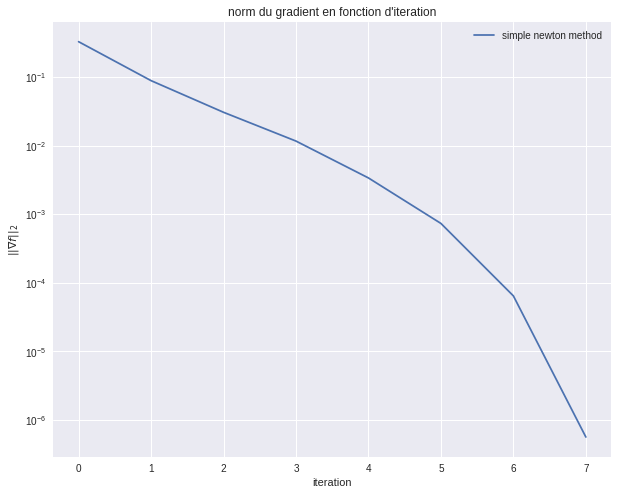

In [9]:
plot_res_logscale([history])

---

## Question 1.4
Lancer avec comme condition initiale $ (\omega^0_0 , w^0 ) = 0.3e $ où $ e_i = 1$ pour tout i. Qu’observez-vous ?

## Reponse 1.4

On observe que la méthode de Newton est divergée en changeant le point initial. Pour éviter divergence on va coder recherche linéaire.

In [10]:
%%time
oracle = LogReg_L2RegOracle(Xone, y, rho)

w2 = np.ones_like(X[0]) * 0.3
w2_0 = 0.3

x2, history2 = newton_method(
    oracle,
    x_0=np.hstack([w2, w2_0]),
    gamma=1,
    eps=1e-10,
    trace=True,
    display=True)
history2['label'] = 'simple newton method (0.3, ..., 0.3)'

func: 0.810082, grad_norm = 0.396898
func: 0.827841, grad_norm = 0.520062
func: 1.251516, grad_norm = 0.272781
func: 4.028238, grad_norm = 0.429418
func: inf, grad_norm = 0.386907
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan


/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in square
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
f

func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
f

func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
f

func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
func: nan, grad_norm = nan
f

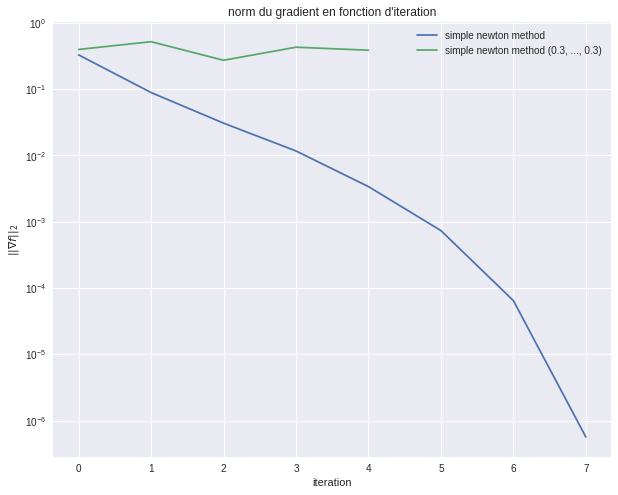

In [11]:
plot_res_logscale([history, history2])

---

## Question 1.5
La solution classique au problème observé à la question précédente est de rajouter une
étape de recherche linéaire. Coder la recherche linéaire d’Armijo en justifiant vos choix des
paramètres.

## Reponse 1.5

le choix des paramètres est classique, pour améliorer un peu les résultats on peut effectuer le gridsearch après.

In [12]:
def linesearch(oracle, xk, gamma, a=0.5, b=None, beta=0.5):
    """
    Armijo's line search
    Parameters
    ----------
    oracle : 
        Oracle with .func(), .grad() methods implemented for computing
        function value, its gradient.
    x_k : np.array
        Starting point for line search
    gamma : float
        initial learning rate
    a : float
        line search parameter
    b : float
        line search base
        
    beta : bool
        Armijo's line search parameter, with `beta` = 0.5 that line search
        is equivalent to Taylor-based line search
    
    Returns
    -------
    gamma : float
        New learning rate, that verifies the condition
    
    """
    if b is None:
        b = 2 * gamma

    l = 1
    f_xk = oracle.func(xk)
    grad_xk = oracle.grad(xk)
    hess = oracle.hess(xk)
    d = np.linalg.solve(hess, grad_xk)

    while True:
        xplus = xk - b * np.power(a, l) * d

        if (oracle.func(xplus) < f_xk + beta * np.dot(grad_xk, xplus - xk)):
            break
        l += 1

    return b * np.power(a, l)

In [13]:
def newton_method_ls(oracle,
                     x_0,
                     gamma=1,
                     eps=1e-10,
                     max_iter=1000,
                     beta=0.5,
                     trace=False,
                     display=False):
    """
    Newton's optimization method with linesearch
    Parameters
    ----------
    oracle : 
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. 
    x_0 : np.array
        Starting point for optimization algorithm
    gamma : float
        Learning rate
    eps : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    beta : float
        line search beta
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
        
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['gamma'] : list of learning rate values produced by line search procedure
   
    """
    start_time = datetime.now()
    history = defaultdict(list) if trace else None

    x = x_0.copy()

    for i in range(max_iter):
        grad = oracle.grad(x)
        H = oracle.hess(x)
        gamma = linesearch(oracle, x, gamma)

        x = x - gamma * np.linalg.inv(H).dot(grad)

        grad_norm = np.linalg.norm(grad)
        if grad_norm <= eps:
            break

        if display:
            print('func: %f, grad_norm = %f' % (oracle.func(x), grad_norm))

        if trace:
            history['time'].append(
                (datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x))
            history['grad_norm'].append(grad_norm)
            #
            history['gamma'].append(gamma)

    return x, history

In [14]:
%%time
oracle = LogReg_L2RegOracle(Xone, y, rho)

w2 = np.ones_like(X[0]) * 0.3
w2_0 = 0.3

x2_ls, history2_ls = newton_method_ls(
    oracle,
    x_0=np.hstack([w2, w2_0]),
    gamma=1,
    eps=1e-7,
    trace=True,
    display=True)
history2_ls['label'] = 'linesearch newton method (0.3, ..., 0.3)'

func: 0.561101, grad_norm = 0.396898
func: 0.542096, grad_norm = 0.061183
func: 0.534331, grad_norm = 0.032058
func: 0.531402, grad_norm = 0.017093
func: 0.530426, grad_norm = 0.009017
func: 0.530132, grad_norm = 0.004695
func: 0.530049, grad_norm = 0.002415
func: 0.530027, grad_norm = 0.001230
func: 0.530021, grad_norm = 0.000622
func: 0.530019, grad_norm = 0.000313
func: 0.530019, grad_norm = 0.000157
func: 0.530019, grad_norm = 0.000079
func: 0.530019, grad_norm = 0.000039
func: 0.530019, grad_norm = 0.000020
func: 0.530019, grad_norm = 0.000010
func: 0.530019, grad_norm = 0.000005
func: 0.530019, grad_norm = 0.000002
func: 0.530019, grad_norm = 0.000001
func: 0.530019, grad_norm = 0.000001
func: 0.530019, grad_norm = 0.000000
func: 0.530019, grad_norm = 0.000000
CPU times: user 1.72 s, sys: 4.2 s, total: 5.92 s
Wall time: 837 ms


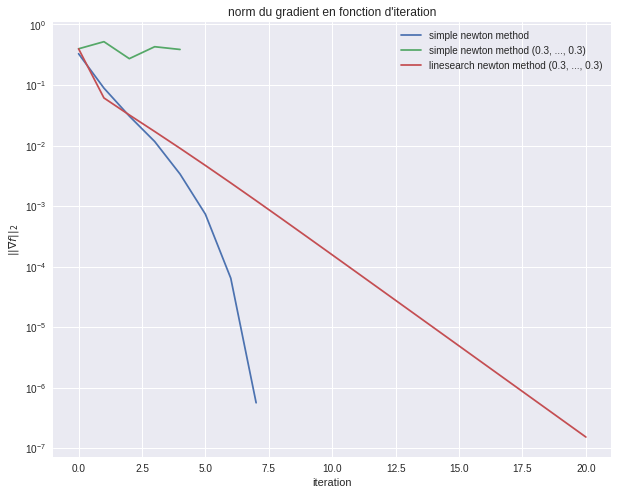

In [15]:
plot_res_logscale([history, history2, history2_ls])

---

# 2 Régularisation pour la parcimonie

On s’intéresse toujours au problème de régression logistique mais on change la régularisation.

$$ \min_{\omega_0 \in \mathbb{R}, \omega \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n log(1+exp(-y_i(x_i^T\omega + \omega_0))) + \rho\| \omega \|_1$$

## Question 2.1
Pourquoi ne peut-on pas utiliser la méthode de Newton pour résoudre ce problème ?

## Reponse 2.1

Non, parce que le terme de régularization n'est pas différentiable

---

## Question 2.2
Écrire la fonction objectif sous la forme $ F_2 = f_2 + g_2$ où $f_2$ est dérivable et l’opérateur
proximal de $g_2$ est simple. Donner la formule de l’opérateur proximal de $g_2$ . Calculer le
gradient de $f_2$ . La fonction objectif est-elle convexe ?

$$ f_2 =  \frac{1}{n} \sum_{i=1}^n log(1+exp(-y_i(x_i^T\omega + \omega_0)))$$

Le gradient:

$$ \frac{\partial f_1}{\partial \omega} = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i(x^T_i \omega + \omega_0))}{1 + exp(-y_i(x^T_i \omega + \omega_0))} (-y_i x_i)  $$

$$ \frac{\partial f_1}{\partial \omega_0} = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i(x^T_i \omega + \omega_0))}{1 + exp(-y_i(x^T_i \omega + \omega_0))} (-y_i) $$

Si on rajoute colonne de uns à la matrice X:

$$ \frac{\partial f_1}{\partial \omega_k } = \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i x^T_i \omega)}{1 + exp(-y_i x^T_i \omega)} (-y_i x_{ik}) $$ 

$$ G = \frac{1}{n}  (diag(-y) X)^Td $$

Pour le fonction simple:

$$ g_2 = \rho\| \omega \|_1$$

On peut calculer l'opérateur proximal dans la forme fermé pour chacun coordonne séparément

$$ [prox_{\gamma g_2} (x)]_i =  \begin{cases} 
                          x_i + \gamma\rho & if & x_i < -\gamma\rho \\
                          0              & if & |x_i| < \gamma\rho \\
                          x_i - \gamma\rho & if & x_i > \gamma\rho 
                     \end{cases} 
                     $$

## Reponse 2.2

In [16]:
class BaseSmoothOracle(object):
    """
    Base class for smooth function.
    """

    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func is not implemented.')

    def grad(self, x):
        """
        Computes the gradient vector at point x.
        """
        raise NotImplementedError('Grad is not implemented.')


class BaseProxOracle(object):
    """
    Base class for proximal h(x)-part in a composite function f(x) + h(x).
    """

    def func(self, x):
        """
        Computes the value of h(x).
        """
        raise NotImplementedError('Func is not implemented.')

    def prox(self, x, alpha):
        """
        Implementation of proximal mapping.
        prox_{alpha}(x) := argmin_y { 1/(2*alpha) * ||y - x||_2^2 + h(y) }.
        """
        raise NotImplementedError('Prox is not implemented.')


class CompositeOracle(object):
    """
    Base class for the composite function.
    phi(x) := f(x) + h(x), where f is a smooth part, h is a simple part.
    """

    def __init__(self, f, h):
        self._f = f
        self._h = h

    def func(self, x):
        """
        Computes the f(x) + h(x).
        """
        return self._f.func(x) + self._h.func(x)

    def grad(self, x):
        """
        Computes the gradient of f(x).
        """
        return self._f.grad(x)

    def prox(self, x, alpha):
        """
        Computes the proximal mapping.
        """
        return self._h.prox(x, alpha)


class L1RegOracle(BaseProxOracle):
    """
    Oracle for L1-regularizer.
        h(x) = rho * ||x||_1.
    """

    def __init__(self, rho):
        self.rho = rho

    def func(self, x):
        return self.rho * np.linalg.norm(x, 1)

    def prox(self, x, alpha):
        """
        Implementation of proximal mapping.
        prox_{alpha}(x) := argmin_y { 1/(2*alpha) * ||y - x||_2^2 + h(y) }.
        """
        n = x.shape[0]
        result = np.zeros(n)
        alpha2 = alpha * self.rho
        for i in range(n):
            if x[i] < -alpha2:
                result[i] = x[i] + alpha2
            elif x[i] > alpha2:
                result[i] = x[i] - alpha2

        return result


class LogRegOracle(BaseSmoothOracle):
    def __init__(self, X, y, rho):
        self._X = X
        self._y = y
        self._rho = rho

    def func(self, x):
        tmp = -self._y * np.dot(self._X, x)
        return np.mean(np.log(1 + np.exp(tmp)))

    def grad(self, x):
        tmp = -self._y * np.dot(self._X, x)
        d = np.exp(tmp) / (1 + np.exp(tmp))
        return np.dot(np.diag(-self._y), self._X).T.dot(d) / len(self._y)

    def hess(self, x):
        tmp = -self._y * np.dot(self._X, x)
        D = np.diag(np.exp(tmp) / (1 + np.exp(tmp)))
        H = self._X.T.dot(D).dot(self._X) / len(self._y)
        return H


def create_logreg_l1reg_prox_oracle(X, y, rho):
    f = LogRegOracle(X, y, rho)
    g = L1RegOracle(rho)
    return CompositeOracle(f, g)

---

## Question 2.3
Coder le gradient proximal avec recherche linéaire. Ici, on prendra $ \rho = 0.1$ . Quel test d’arrêt proposeriez-vous ?

In [17]:
def proximal_linesearch(oracle, xk, gamma, a=0.5, b=None, beta=0.5,
                        t='taylor'):
    """
    Armijo's or Taylor's line search
    Parameters
    ----------
    oracle : 
        Oracle with ._f.func(), _f.grad(), .prox() methods implemented for computing
        function value, function gradient, and proximal mapping.
    xk : np.array
        Starting point for line search
    gamma : float
        initial learning rate
    a : float
        line search parameter
    b : float
        line search base
    beta : float
        Armijo's line search parameter, with `beta` = 0.5 that line search
        is equivalent to Taylor-based line search
    t : string
        choose 'armijo' or 'taylor'

    Returns
    -------
    gamma : float
        New learning rate, that verifies the condition

    """
    if b is None:
        b = 2 * gamma

    l = 1
    f_xk = oracle._f.func(xk)
    grad_f_xk = oracle._f.grad(xk)

    while True:
        gamma = b * np.power(a, l)
        xplus = oracle.prox(xk - gamma * grad_f_xk, gamma)

        if t == 'armijo':
            if (oracle._f.func(xplus) <
                    f_xk + beta * np.dot(grad_f_xk, xplus - xk)):
                break

        if t == 'taylor':
            if (oracle._f.func(xplus) < f_xk + np.dot(grad_f_xk, xplus - xk) +
                    np.linalg.norm(xplus - xk)**2 / (2 * gamma)):
                break
        l += 1

    return gamma

In [18]:
def proximal_gradient_descent(oracle,
                              x_0,
                              gamma=1,
                              eps=1e-5,
                              max_iter=1000,
                              trace=False,
                              display=False):
    """
    Proximal gradient descent for composite optimization.
    Parameters
    ----------
    oracle : CompositeOracle-descendant object
        Oracle with .func() and .grad() and .prox() methods implemented
        for computing function value, its gradient and proximal mapping
        respectively.
        
    x_0 : 1-dimensional np.array
        Starting point of the algorithm
    gamma : float
        Initial value for line-search.
    eps : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace:  bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        
    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure

    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
    """
    start_time = datetime.now()
    history = defaultdict(list) if trace else None

    x = x_0.copy()

    for i in range(max_iter):

        f_x = oracle.func(x)
        grad_f_x = oracle._f.grad(x)
        gamma = proximal_linesearch(oracle, x, gamma)

        x = oracle.prox(x - gamma * grad_f_x, gamma)

        grad_norm = np.linalg.norm(grad_f_x)
        if grad_norm <= eps:
            break

        diff = f_x - oracle.func(x)
        if diff <= eps:
            break

        if display:
            print('func: %f, grad_norm = %f' % (oracle.func(x), grad_norm))

        if trace:
            history['time'].append(
                (datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x))
            history['grad_norm'].append(grad_norm)
            #
            history['gamma'].append(gamma)

    return x, history

In [19]:
%%time
proximal_logreg_oracle = create_logreg_l1reg_prox_oracle(Xone, y, rho=0.05)
x_0 = np.hstack([w, w_0]) + 0.3

x_l1, history_l1 = proximal_gradient_descent(
    proximal_logreg_oracle,
    x_0,
    gamma=1,
    eps=1e-8,
    max_iter=100,
    trace=True,
    display=False)

CPU times: user 3.1 s, sys: 7.37 s, total: 10.5 s
Wall time: 1.48 s


In [20]:
x_l1

array([ 0.       ,  0.       ,  0.3802364,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.1169535,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ])

---

# Comparison

## Question 3.1
Comparer les propriétés des deux problèmes d’optimisation.

## Question 3.2
Comparer les solutions obtenues avec les deux types de régularisation.

## Reponse 3.1 et 3.2

Tous les deux types de régularisation nous permettent de limite les valeurs de paramètres du modèle

1. l2-régularisation problèmes est convexe est différentiable. Il est plus facile d'optimiser et on peut utiliser la méthode de second ordre comme la méthode de Newton

2. l1-régularization problèmes est convexe, mais n'est pas différentiable. Alors on a besoin d'utiliser le méthode de **proximal gradient descent**. On a beaucoup de zéro éléments dans la solution, ça veut dire que ce type de régularisation permet de faire la sélection de variables


---

In [21]:
%%time
oracle = LogReg_L2RegOracle(Xone, y, rho)

w2 = np.ones_like(X[0]) * 0.3
w2_0 = 0.3

x2_ls, history2_ls = newton_method_ls(
    oracle,
    x_0=np.hstack([w2, w2_0]),
    gamma=1,
    eps=1e-8,
    trace=True,
    display=True)
history2_ls['label'] = 'linesearch newton method (0.3, ..., 0.3)'

func: 0.561101, grad_norm = 0.396898
func: 0.542096, grad_norm = 0.061183
func: 0.534331, grad_norm = 0.032058
func: 0.531402, grad_norm = 0.017093
func: 0.530426, grad_norm = 0.009017
func: 0.530132, grad_norm = 0.004695
func: 0.530049, grad_norm = 0.002415
func: 0.530027, grad_norm = 0.001230
func: 0.530021, grad_norm = 0.000622
func: 0.530019, grad_norm = 0.000313
func: 0.530019, grad_norm = 0.000157
func: 0.530019, grad_norm = 0.000079
func: 0.530019, grad_norm = 0.000039
func: 0.530019, grad_norm = 0.000020
func: 0.530019, grad_norm = 0.000010
func: 0.530019, grad_norm = 0.000005
func: 0.530019, grad_norm = 0.000002
func: 0.530019, grad_norm = 0.000001
func: 0.530019, grad_norm = 0.000001
func: 0.530019, grad_norm = 0.000000
func: 0.530019, grad_norm = 0.000000
func: 0.530019, grad_norm = 0.000000
func: 0.530019, grad_norm = 0.000000
func: 0.530019, grad_norm = 0.000000
CPU times: user 3.06 s, sys: 7.86 s, total: 10.9 s
Wall time: 1.68 s


In [22]:
%%time
proximal_logreg_oracle = create_logreg_l1reg_prox_oracle(Xone, y, rho=0.01)
x_0 = np.hstack([w, w_0]) + 0.3

x_l1, history_l1 = proximal_gradient_descent(
    proximal_logreg_oracle,
    x_0,
    gamma=1,
    eps=1e-8,
    max_iter=100,
    trace=True,
    display=False)

CPU times: user 4 s, sys: 9.14 s, total: 13.1 s
Wall time: 1.78 s


Le choix de $\rho$ pour $l_1$-régularisation et très restrictif. Si on va prendre $\rho=0.01$. Les deux approches montrent les résultats comparables sur **Train set**. Comparaison de capacité pour la généralisation c'est une autre question.


In [23]:
y_pred_l2 = np.sign(Xone.dot(x2_ls))
y_pred_l1 = np.sign(Xone.dot(x_l1))

print("Rapport de la classification: ")
print("Newton avec recherche linéaire:")
print(classification_report(y, y_pred_l2))
print("Proximal gradient avec recherche linéaire:")
print(classification_report(y, y_pred_l1))

Rapport de la classification: 
Newton avec recherche linéaire:
             precision    recall  f1-score   support

       -1.0       0.69      0.82      0.75       540
        1.0       0.81      0.67      0.73       611

avg / total       0.75      0.74      0.74      1151

Proximal gradient avec recherche linéaire:
             precision    recall  f1-score   support

       -1.0       0.64      0.76      0.70       540
        1.0       0.75      0.63      0.68       611

avg / total       0.70      0.69      0.69      1151

